<a href="https://colab.research.google.com/github/JeMinYoo/1st-Rep/blob/master/polyp_detection/polyp_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.17.0


In [75]:
DATASET_PATH = os.path.join('/content/drive/MyDrive/Colab Notebooks/medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")


In [4]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [5]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [6]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


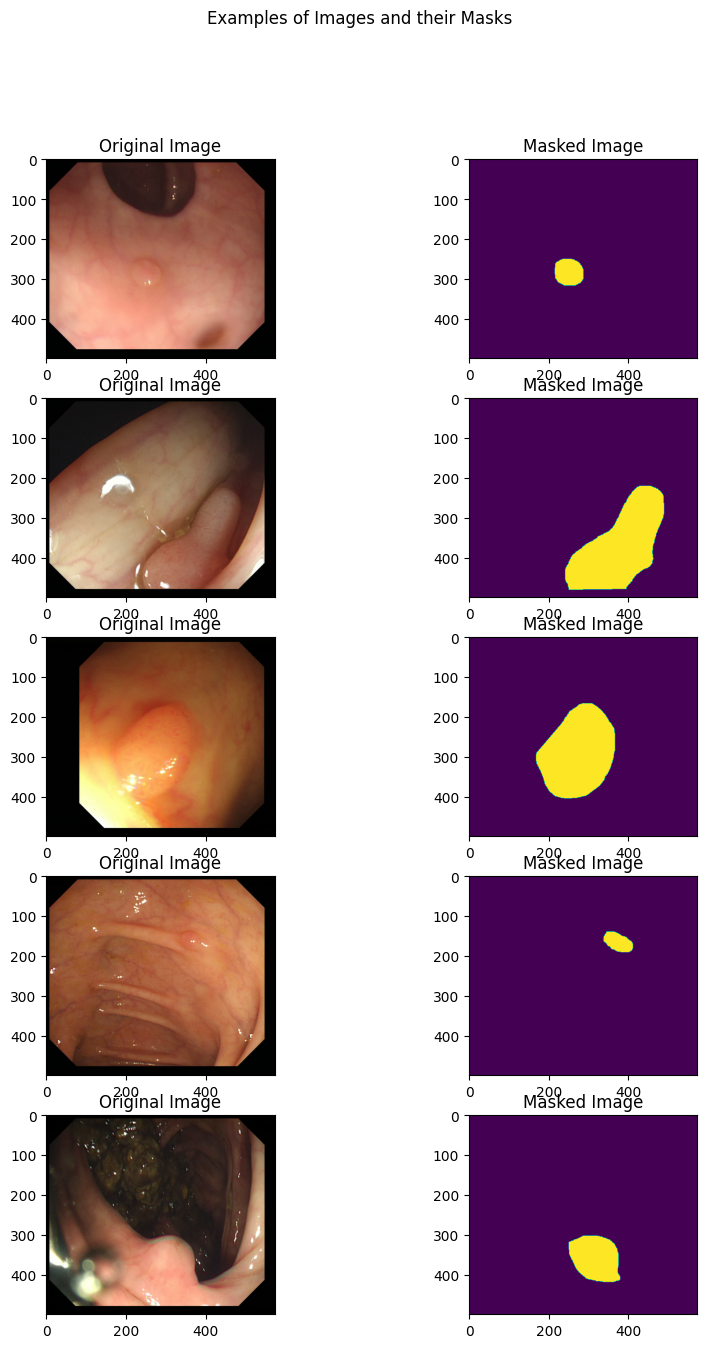

In [7]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")

plt.suptitle("Examples of Images and their Masks")
plt.show()

In [17]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [18]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [26]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This function will perform the horizontal or vertical shift using tf.image."""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                  -width_shift_range,
                                                  width_shift_range)
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range,
                                                   height_shift_range)

        offset_height = tf.maximum(int(height_shift_range * img_shape[0]), 0)
        offset_width = tf.maximum(int(width_shift_range * img_shape[1]), 0)

        output_img = tf.image.pad_to_bounding_box(output_img,
                                                  offset_height=offset_height,
                                                  offset_width=offset_width,
                                                  target_height=img_shape[0] + offset_height,
                                                  target_width=img_shape[1] + offset_width)

        label_img = tf.image.pad_to_bounding_box(label_img,
                                                 offset_height=offset_height,
                                                 offset_width=offset_width,
                                                 target_height=img_shape[0] + offset_height,
                                                 target_width=img_shape[1] + offset_width)

        output_img = tf.image.crop_to_bounding_box(output_img, offset_height, offset_width, img_shape[0], img_shape[1])
        label_img = tf.image.crop_to_bounding_box(label_img, offset_height, offset_width, img_shape[0], img_shape[1])

    return output_img, label_img


In [27]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [28]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [29]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [30]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>

In [31]:
# Using the dataset
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
train_dataset = train_dataset.repeat()

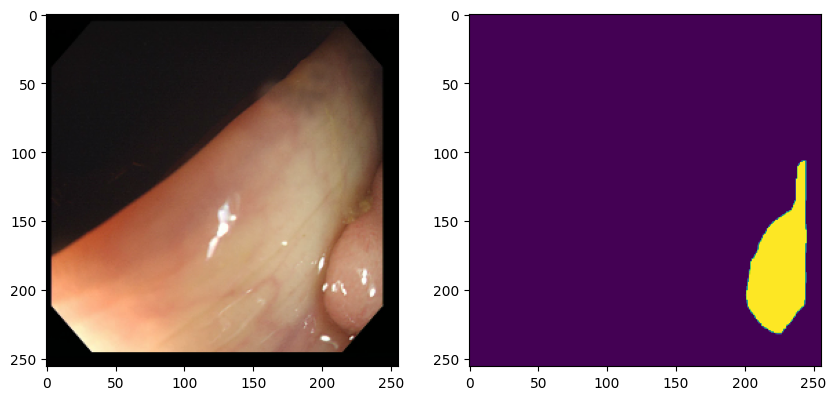

In [32]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

In [33]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [34]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [35]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [36]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [37]:
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

In [38]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [39]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [40]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [41]:
unet_model = UNet()

In [42]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [43]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [44]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [45]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [76]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요.
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다.

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [77]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [78]:
model.summary()

Model: "u_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_block (EncoderBlock)         │ ?                           │          76,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_1 (EncoderBlock)       │ ?                           │         444,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_2 (EncoderBlock)       │ ?                           │       1,773,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_block_3 (EncoderBlock)       │ ?                           │       7,085,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_block_4 (ConvBlock)             │ ?                           │      28,326,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block (DecoderBlock)         │ ?                           │      18,882,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_1 (DecoderBlock)       │ ?                           │       3,542,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_2 (DecoderBlock)       │ ?                           │         886,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_block_3 (DecoderBlock)       │ ?                           │         222,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (8, 256, 256, 1)            │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,685,253 (700.70 MB)

 Trainable params: 61,222,529 (233.55 MB)

 Non-trainable params: 17,664 (69.00 KB)

 Optimizer params: 122,445,060 (467.09 MB)

In [80]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [81]:
# Import the necessary module
from tensorflow.keras.optimizers.schedules import CosineDecay

# Define the cosine decay learning rate schedule
cos_decay = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=max_epochs,
    alpha=0.0  # Minimum learning rate value as a fraction of initial_learning_rate
)

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: float(cos_decay(epoch).numpy()), verbose=1)


In [82]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [83]:
# 모델 학습 코드
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples // batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - dice_loss: 0.6868 - loss: 0.9010
Epoch 1: val_loss improved from inf to 4.43904, saving model to /content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 491ms/step - dice_loss: 0.6870 - loss: 0.9012 - val_dice_loss: 1.0000 - val_loss: 4.4390 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009755282662808895.
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - dice_loss: 0.6579 - loss: 0.8614
Epoch 2: val_loss improved from 4.43904 to 1.90233, saving model to /content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 652ms/step - dice_loss: 0.6578 - loss: 0.8612 - val_dice_loss: 1.0000 - val_loss: 1.9023 - learning_rate: 9.7553e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009045085171237588.
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - dice_loss: 0.6622 - loss: 0.8668
Epoch 3: val_loss did not improve from 1.90233
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - dice_loss: 0.6617 - loss: 0.8660 - val_dice_loss: 0.9995 - val_loss: 2.7018 - learning_rate: 9.0451e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007938926573842764.
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - dice_loss: 0.6121 - loss: 0.7934
Epoch 4: val_loss improved from 1.90233 to 0.97702, saving model to /content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 415ms/step - dice_loss: 0.6115 - loss: 0.7929 - val_dice_loss: 0.8804 - val_loss: 0.9770 - learning_rate: 7.9389e-04

Epoch 5: LearningRateSched

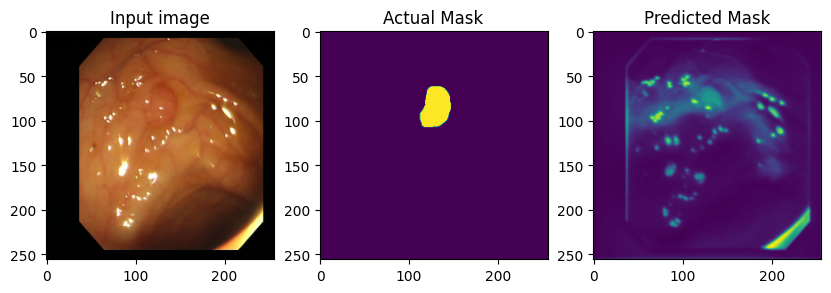

In [84]:
# print sample image after training
print_images()

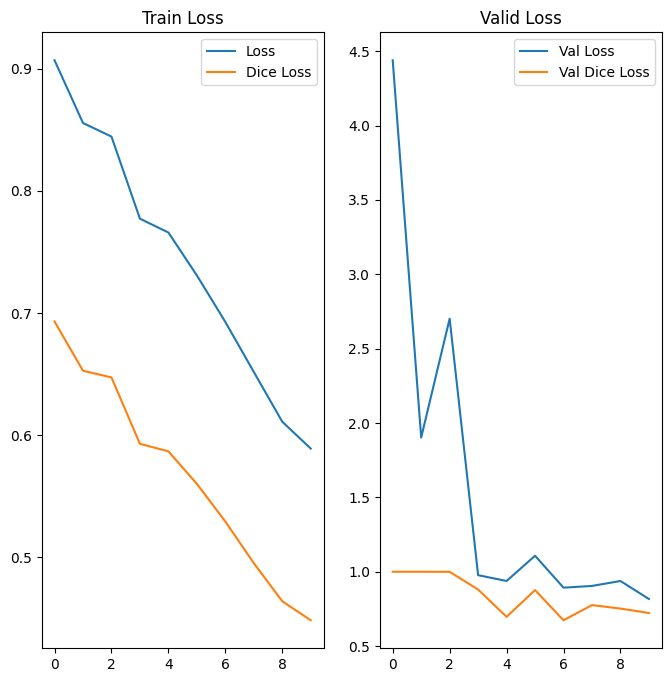

In [85]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [87]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights('/content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5')

In [88]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [89]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.49153194788069055


In [90]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

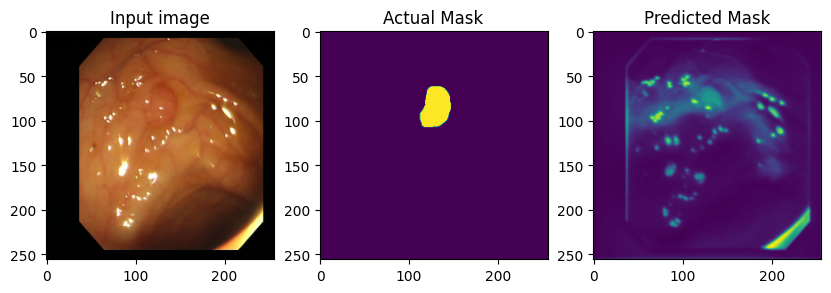

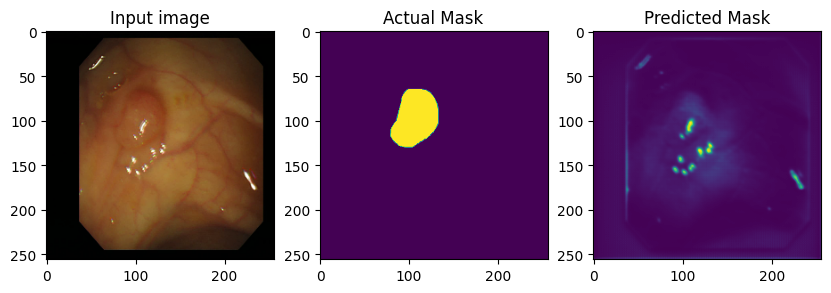

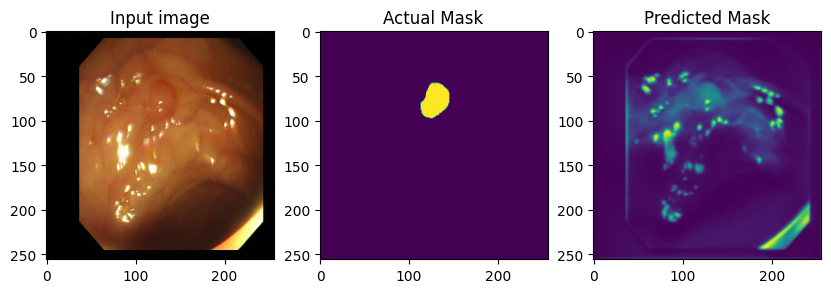

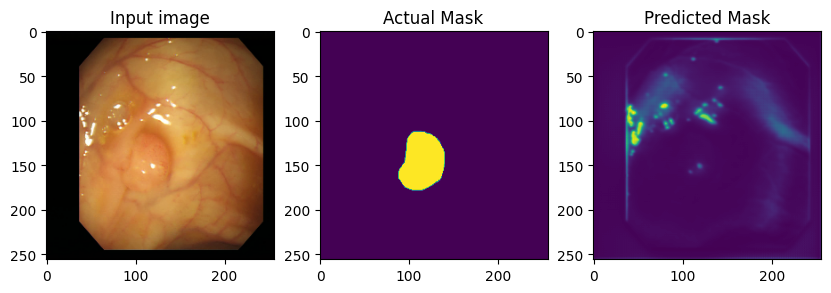

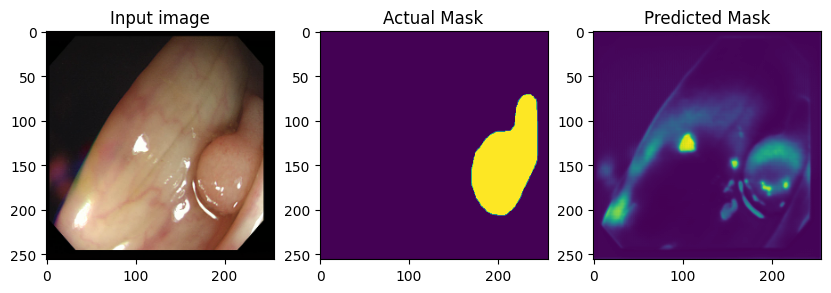

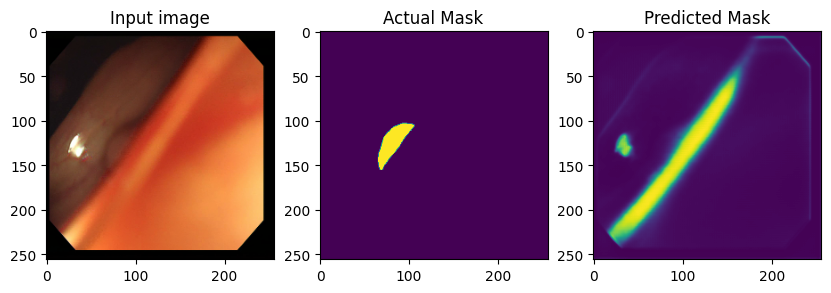

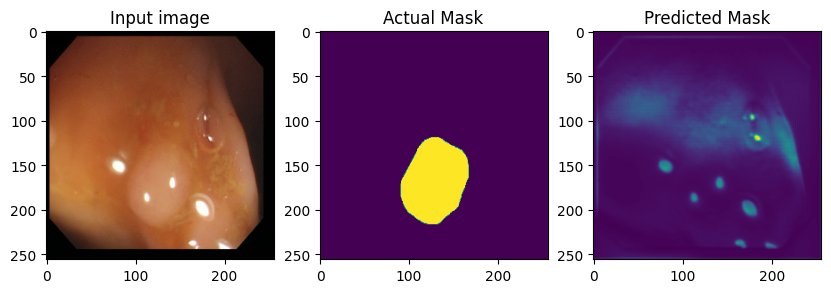

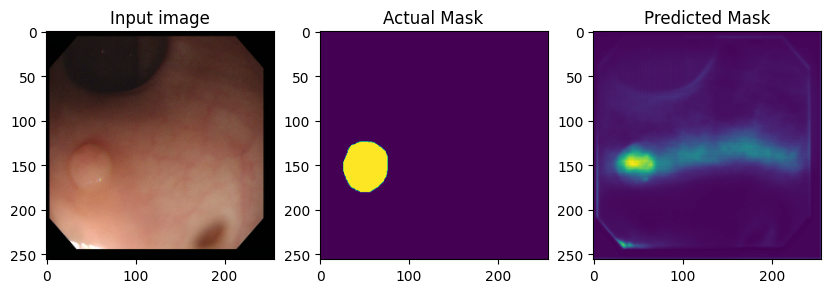

In [91]:
print_images()

# Encoder-Decoder 모델

In [97]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요.
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다.

print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

# print('select the U-Net model')
# model = unet_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the Encoder-Decoder model


In [104]:
# 옵티마이저 다시 정의 (예시: Adam 옵티마이저)
optimizer = tf.keras.optimizers.Adam(learning_rate=cos_decay)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

# 모델 예측 테스트
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [105]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Sequential)                 │ (8, 16, 16, 512)            │       4,693,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Sequential)                 │ (8, 256, 256, 1)            │       2,354,913 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,047,969 (26.89 MB)

 Trainable params: 7,042,209 (26.86 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [106]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/ed_model.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [107]:
# Import the necessary module
from tensorflow.keras.optimizers.schedules import CosineDecay

# Define the cosine decay learning rate schedule
cos_decay = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=max_epochs,
    alpha=0.0  # Minimum learning rate value as a fraction of initial_learning_rate
)

# Create the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: float(cos_decay(epoch).numpy()), verbose=1)


In [108]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [109]:
# 모델 학습 코드
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples // batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [ ]:
# print sample image after training
print_images()

In [ ]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [ ]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
# checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights('/content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5')

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

In [ ]:
print_images()

# Pretrained U-Net 모델

In [92]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=None, name=keras_tensor_91>,
 <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_92>,
 <KerasTensor shape=(None, 256, 256, 64), dtype=float32, sparse=False, name=keras_tensor_93>,
 <KerasTensor shape=(None, 128, 128, 64), dtype=float32, sparse=False, name=keras_tensor_94>,
 <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_95>,
 <KerasTensor shape=(None, 128, 128, 128), dtype=float32, sparse=False, name=keras_tensor_96>,
 <KerasTensor shape=(None, 64, 64, 128), dtype=float32, sparse=False, name=keras_tensor_97>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_98>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_99>,
 <KerasTensor shape=(None, 64, 64, 256), dtype=float32, sparse=False, name=keras_tensor_100>,
 <KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=

In [93]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input,
                                      outputs=[layer_outputs[2],
                                               layer_outputs[5],
                                               layer_outputs[9],
                                               layer_outputs[13],
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models

img_shape = (256, 256, 3)

class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)
        return x

class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        return encoder

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = Conv(num_filters, 3)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)
        return decoder

class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input,
                                      outputs=[layer_outputs[2],
                                               layer_outputs[5],
                                               layer_outputs[9],
                                               layer_outputs[13],
                                               layer_outputs[17]])

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)
        return outputs


In [95]:
model = Vgg16UNet()

def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
    return loss

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=num_train_examples // 8,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples // 8,
                    callbacks=[cp_callback]
                    )


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'vgg16u_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - dice_loss: 0.7299 - loss: 1.1349
Epoch 1: val_loss improved from inf to 1.22424, saving model to /content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - dice_loss: 0.7289 - loss: 1.1307 - val_dice_loss: 0.8649 - val_loss: 1.2242
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - dice_loss: 0.6243 - loss: 0.8267
Epoch 2: val_loss did not improve from 1.22424
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - dice_loss: 0.6236 - loss: 0.8260 - val_dice_loss: 0.9196 - val_loss: 1.4296
Epoch 3/10
 1/30 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - dice_loss: 0.5210 - loss: 0.6934

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - dice_loss: 0.5487 - loss: 0.7261
Epoch 3: val_loss did not improve from 1.22424
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - dice_loss: 0.5487 - loss: 0.7261 - val_dice_loss: 0.8163 - val_loss: 2.0317
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - dice_loss: 0.5271 - loss: 0.6889
Epoch 4: val_loss did not improve from 1.22424
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - dice_loss: 0.5263 - loss: 0.6881 - val_dice_loss: 0.9549 - val_loss: 4.3811
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - dice_loss: 0.4731 - loss: 0.6315
Epoch 5: val_loss improved from 1.22424 to 0.94149, saving model to /content/drive/MyDrive/Colab Notebooks/medical/train_ckpt/unet_model.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - dice_loss: 0.4733 - loss: 0.6316 - val_dice_loss: 0.5981 - val_loss: 0.9415
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - dice_loss: 0.4004 - loss: 0.5366
Epoch 6: val_loss did not improve from 0.94149
30/30 ━━━━━━━━━━

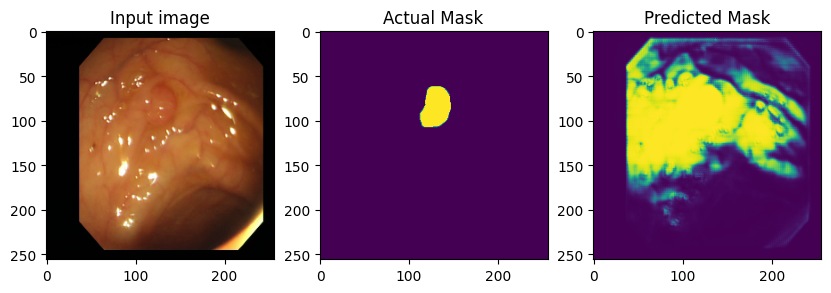

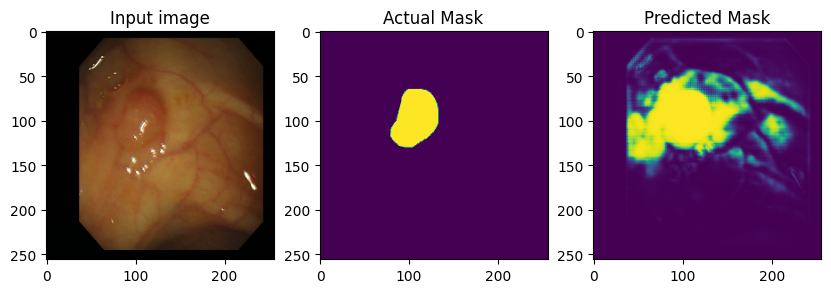

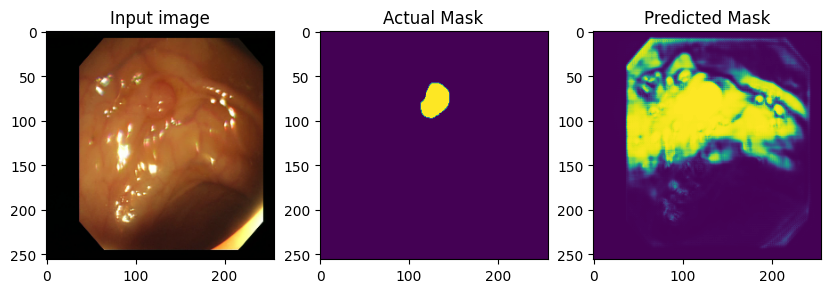

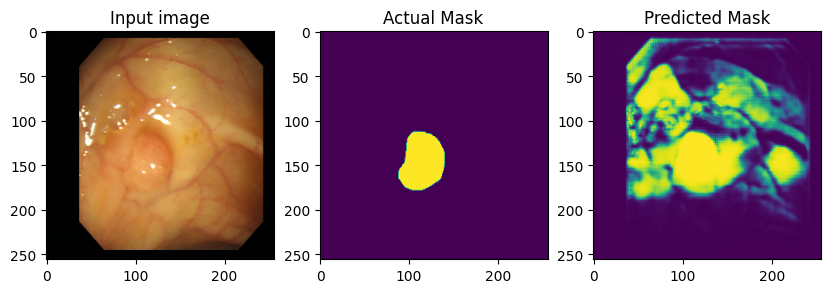

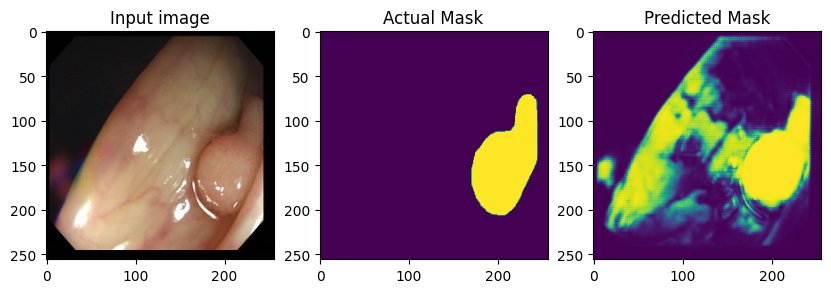

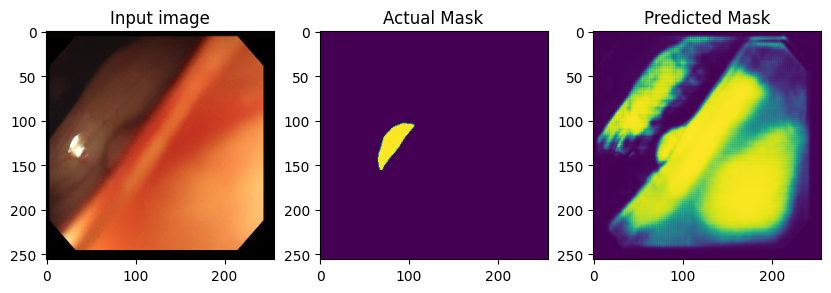

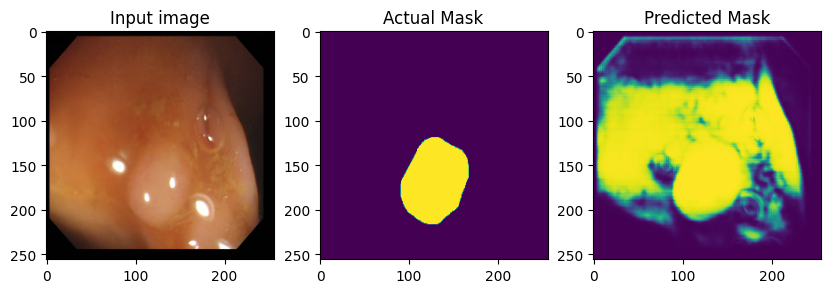

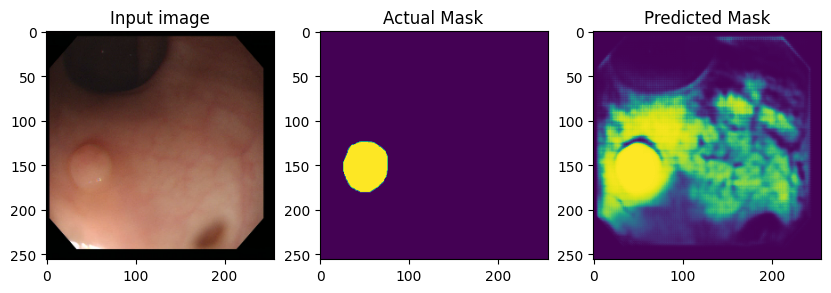

In [96]:
print_images()


# 총평
3가지 모델 Encoder-Decoder 모델은 학습 시 생기는 오류를 해결하지 못하여 U-Net 모델, Pretrained U-Net 모델 2가지만 테스트 진행했으며 Pretrained U-Net 모델이 가장 좋은 결과를 보였다.

# 회고
LMS에서 진행할 땐 문제가 없었으나 Colab에서 진행시 여러 오류가 생겨 많은 어려움이 있었다. 이러한 오류들을 빨리 잡고 진행할 수 있었다면 더 좋은 결과를 낼 수 있었을텐데...하는 생각이 드는 퀘스트였습니다.
오류가 생겼을 때 더 능동적이고 확실하게 해결할 수 있도록 많은 경험이 필요할거 같습니다.